<h3>Project Overview:</h3>

<ol>
    <li><strong>Data Transformation:</strong> We will preprocess the data by converting date formats and calculating daily returns. This step is crucial for preparing the data for in-depth analysis.</li>
    <li><strong>Data Analysis:</strong> Utilizing Spark SQL, we will analyze the average daily returns and trading volumes on a monthly basis. This analysis aims to identify patterns and trends in the cryptocurrency market.</li>
    <li><strong>Visualization:</strong> To make our findings accessible, we will visualize the analysis results. Visual representations will help in effectively communicating the insights derived from our data.</li>
</ol>

<p>By the end of this project, we aim to provide valuable insights into the cryptocurrency market, aiding in decision-making and strategy formulation for stakeholders.</p>


In [0]:
# Load the data by explicitly specifying the catalog
df = spark.table("hive_metastore.default.btc_usd_max")

# Show the first few rows to verify the data
df.show(5)


+-------------------+------+-------------+------------+
|         snapped_at| price|   market_cap|total_volume|
+-------------------+------+-------------+------------+
|2013-04-28 00:00:00| 135.3| 1.50051759E9|         0.0|
|2013-04-29 00:00:00|141.96|1.575032004E9|         0.0|
|2013-04-30 00:00:00| 135.3|1.501657493E9|         0.0|
|2013-05-01 00:00:00| 117.0| 1.29895155E9|         0.0|
|2013-05-02 00:00:00|103.43|1.148667722E9|         0.0|
+-------------------+------+-------------+------------+
only showing top 5 rows



<h3>Description:</h3>

<p>
    In the following steps, we will perform data transformation and analysis on the historical cryptocurrency data. Specifically, we will:
</p>

<ol>
    <li>
        <strong>Transform the Data:</strong> Convert the date format and calculate the daily returns based on the price of the cryptocurrency. Daily return is a key metric that reflects the percentage change in the price from one day to the next, providing insights into the asset's performance and volatility.
    </li>
    <li>
        <strong>Analyze the Data:</strong> Using Spark SQL, we will compute the average daily returns and trading volumes on a monthly basis. This analysis will help us understand the overall trends and patterns in the cryptocurrency market over time.
    </li>
    <li>
        <strong>Visualize the Results:</strong> Finally, we will visualize the results to make the insights more accessible and easier to interpret.
    </li>
</ol>


In [0]:
# Select relevant columns (adjust the column names as necessary)
df_selected = df.select("snapped_at", "price", "total_volume")

# Convert the 'snapped_at' column to a Date type (if it's not already)
from pyspark.sql.functions import to_date
df_selected = df_selected.withColumn("Date", to_date(df_selected["snapped_at"], "yyyy-MM-dd"))

# Calculate daily returns based on the 'price' column
from pyspark.sql.functions import lag, col
from pyspark.sql.window import Window

windowSpec = Window.orderBy("Date")
df_transformed = df_selected.withColumn("PrevPrice", lag("price").over(windowSpec))
df_transformed = df_transformed.withColumn("DailyReturn", (col("price") - col("PrevPrice")) / col("PrevPrice"))

# Show the transformed DataFrame
df_transformed.show(5)


+-------------------+------+------------+----------+---------+--------------------+
|         snapped_at| price|total_volume|      Date|PrevPrice|         DailyReturn|
+-------------------+------+------------+----------+---------+--------------------+
|2013-04-28 00:00:00| 135.3|         0.0|2013-04-28|     NULL|                NULL|
|2013-04-29 00:00:00|141.96|         0.0|2013-04-29|    135.3| 0.04922394678492237|
|2013-04-30 00:00:00| 135.3|         0.0|2013-04-30|   141.96|-0.04691462383770073|
|2013-05-01 00:00:00| 117.0|         0.0|2013-05-01|    135.3|-0.13525498891352558|
|2013-05-02 00:00:00|103.43|         0.0|2013-05-02|    117.0|-0.11598290598290592|
+-------------------+------+------------+----------+---------+--------------------+
only showing top 5 rows



<h3>Description:</h3>

<p>
    In this section, we execute a SQL query to analyze the cryptocurrency data by calculating the average daily return and trading volume, aggregated by both year and month. This approach ensures that we consider the time series nature of the data, allowing us to observe trends and patterns over specific time intervals.
</p>

<p>
    The steps include:
</p>

<ul>
    <li><strong>Calculating Average Daily Return:</strong> We calculate the average daily return for each month of every year, which helps in identifying how the cryptocurrency's returns have evolved over time.</li>
    <li><strong>Calculating Average Trading Volume:</strong> We also compute the average trading volume for each month of every year, which provides insights into the level of market activity during those periods.</li>
    <li><strong>Grouping by Year and Month:</strong> The query groups the data by both year and month to maintain chronological accuracy, ensuring that data from different years is not mixed together.</li>
    <li><strong>Sorting the Results:</strong> Finally, we sort the results by year and month to create a time series that can be easily visualized and interpreted.</li>
</ul>

<p>
    This analysis is essential for understanding long-term trends in the cryptocurrency market, making it possible to identify periods of high volatility, growth, or decline.
</p>


In [0]:
# Run a SQL query to find the average daily return and volume per year and month
average_stats = spark.sql("""
    SELECT YEAR(Date) as Year, MONTH(Date) as Month, AVG(DailyReturn) as AvgDailyReturn, AVG(total_volume) as AvgVolume
    FROM crypto_data
    GROUP BY YEAR(Date), MONTH(Date)
    ORDER BY Year, Month
""")

# Show the result
average_stats.show()


+----+-----+--------------------+--------------------+
|Year|Month|      AvgDailyReturn|           AvgVolume|
+----+-----+--------------------+--------------------+
|2013|    4|0.001154661473610...|                 0.0|
|2013|    5|2.887921871493924E-4|                 0.0|
|2013|    6|-0.00945664812332...|                 0.0|
|2013|    7|0.006665944331674262|                 0.0|
|2013|    8|0.007501604829305362|                 0.0|
|2013|    9|-0.00125120193451...|                 0.0|
|2013|   10| 0.01522648044758983|                 0.0|
|2013|   11|  0.0611481228527903|                 0.0|
|2013|   12|-0.00832902039493...|   5311041.935483871|
|2014|    1|0.003653370986473...| 3.690631935483871E7|
|2014|    2|-0.01135245087843...| 4.529888928571428E7|
|2014|    3|-0.00607316319345...| 2.399571193548387E7|
|2014|    4|0.001033366333019...|2.5527178036796406E7|
|2014|    5| 0.01128100469234379|1.6119226289371552E7|
|2014|    6|0.001410477339554...| 2.195555367124533E7|
|2014|    

%md
<h3>Description:</h3>

<p>
    In this section, we visualize the trends in the average daily returns and trading volumes of the cryptocurrency over time. Specifically, we are creating two line plots that display the average daily return and the average trading volume for each month from 2013 onward.
</p>

<p>
    The steps include:
</p>

<ul>
    <li>Converting the analysis results to a Pandas DataFrame for easier manipulation and plotting.</li>
    <li>Creating a combined 'YearMonth' column to represent each year and month as a single value.</li>
    <li>Using Matplotlib to create two vertically stacked subplots:</li>
    <ul>
        <li><strong>Plot 1:</strong> Displays the average daily return over time, allowing us to observe how the cryptocurrency's return has varied from month to month and year to year.</li>
        <li><strong>Plot 2:</strong> Displays the average trading volume over time, providing insights into how trading activity has fluctuated over the same period.</li>
    </ul>
    <li>To improve readability, we adjust the x-axis to display every 12 months and ensure that the full range of years (up to 2024) is visible on the axis.</li>
    <li>We also use the <code>plt.tight_layout()</code> function to add spacing between the plots for a cleaner presentation.</li>
</ul>

<p>
    These visualizations help us to understand long-term trends in the cryptocurrency market, making it easier to spot patterns and potential correlations between returns and trading volume over time.
</p>


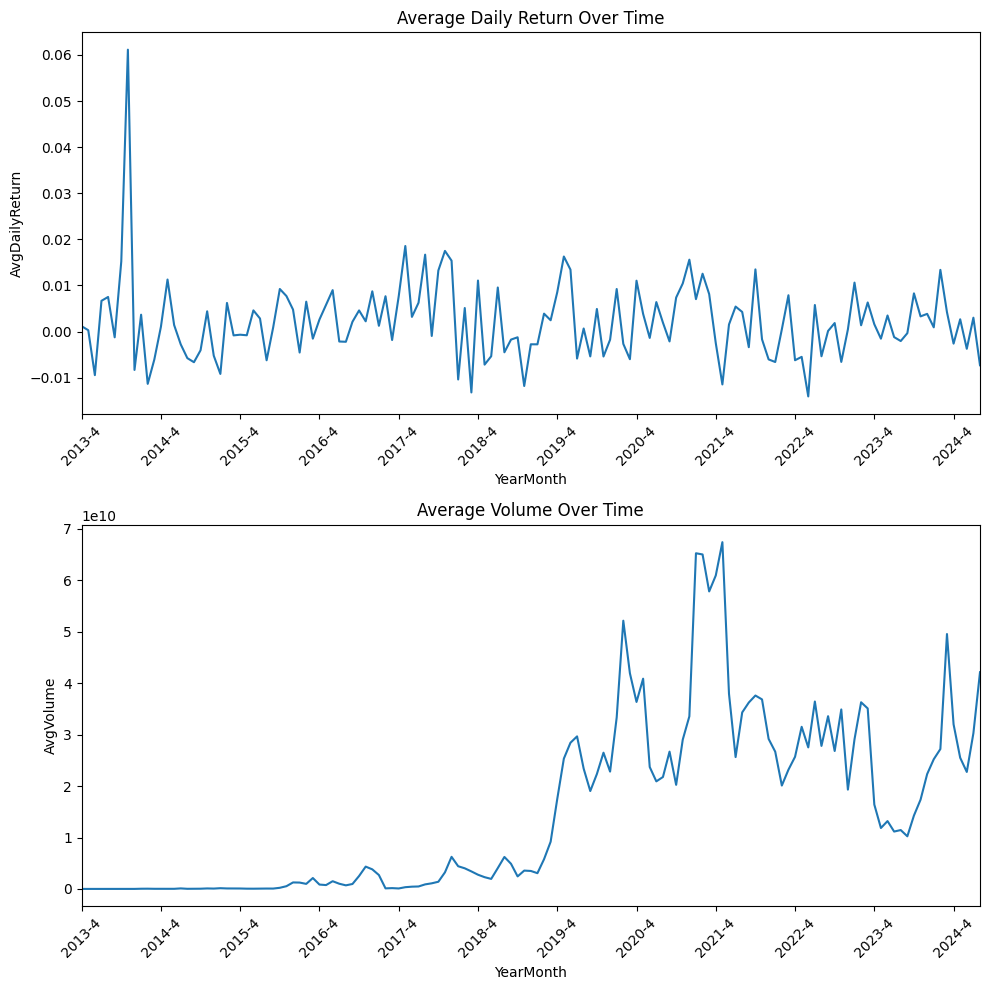

In [0]:
import matplotlib.pyplot as plt

# Convert the results to a Pandas DataFrame for easy plotting
average_stats_pd = average_stats.toPandas()

# Create a combined 'YearMonth' column
average_stats_pd["YearMonth"] = average_stats_pd["Year"].astype(str) + "-" + average_stats_pd["Month"].astype(str)

# Plot the average daily return and volume over time
fig, axs = plt.subplots(2, 1, figsize=(10, 10))  # Create 2 subplots in a single column

# Plot 1: Average Daily Return Over Time
axs[0].plot(average_stats_pd["YearMonth"], average_stats_pd["AvgDailyReturn"], label="AvgDailyReturn")
axs[0].set_title("Average Daily Return Over Time")
axs[0].set_xlabel("YearMonth")
axs[0].set_ylabel("AvgDailyReturn")
axs[0].set_xticks(range(0, len(average_stats_pd["YearMonth"]), 12))  # Adjust x-axis ticks to show every 12 months
axs[0].tick_params(axis='x', rotation=45)
axs[0].set_xlim([0, len(average_stats_pd["YearMonth"]) - 1])

# Plot 2: Average Volume Over Time
axs[1].plot(average_stats_pd["YearMonth"], average_stats_pd["AvgVolume"], label="AvgVolume")
axs[1].set_title("Average Volume Over Time")
axs[1].set_xlabel("YearMonth")
axs[1].set_ylabel("AvgVolume")
axs[1].set_xticks(range(0, len(average_stats_pd["YearMonth"]), 12))  # Adjust x-axis ticks to show every 12 months
axs[1].tick_params(axis='x', rotation=45)
axs[1].set_xlim([0, len(average_stats_pd["YearMonth"]) - 1])

# Adjust layout to add space between plots
plt.tight_layout()

# Show the plots
plt.show()


<h3>Description:</h3>

<p>
    In this step, we load the additional cryptocurrency datasets for Ethereum (ETH) and Solana (SOL) into Spark DataFrames. These datasets, along with the previously loaded Bitcoin (BTC) dataset, will allow us to perform a comparative analysis across these different cryptocurrencies.
</p>

<p>
    The steps include:
</p>

<ul>
    <li><strong>Loading the Data:</strong> We use the <code>spark.table()</code> function to load the ETH and SOL data from the Hive metastore into separate DataFrames.</li>
    <li><strong>Verification:</strong> After loading, we display the first few rows of each DataFrame to verify that the data has been loaded correctly.</li>
</ul>

<p>
    This step is crucial as it prepares the datasets for further transformation, analysis, and comparison. By loading these datasets into separate DataFrames, we maintain a clear and organized structure, making it easier to perform subsequent operations.
</p>


In [0]:
# Load the data for Ethereum (ETH) and Solana (SOL)
df_eth = spark.table("hive_metastore.default.eth_usd_max")
df_sol = spark.table("hive_metastore.default.sol_usd_max")

# Show the first few rows to verify the data
df_eth.show(5)
df_sol.show(5)


+-------------------+------------------+--------------------+------------------+
|         snapped_at|             price|          market_cap|      total_volume|
+-------------------+------------------+--------------------+------------------+
|2015-08-07 00:00:00|           2.83162|                 0.0|           90622.0|
|2015-08-08 00:00:00|           1.33075|         8.0339475E7|          368070.0|
|2015-08-10 00:00:00|0.6875857090838133| 4.155630921112176E7| 400464.0745435489|
|2015-08-11 00:00:00| 1.067378879429946|6.4539006306272194E7|1518998.2053373822|
|2015-08-12 00:00:00| 1.256613175101658| 7.601326105415402E7|2073893.3450314845|
+-------------------+------------------+--------------------+------------------+
only showing top 5 rows

+-------------------+------------------+-----------------+--------------------+
|         snapped_at|             price|       market_cap|        total_volume|
+-------------------+------------------+-----------------+--------------------+
|2020-

<h3>Description:</h3>

<p>
    In this step, we perform data transformation on the Ethereum (ETH) and Solana (SOL) datasets. The goal is to prepare these datasets for direct comparison with the previously transformed Bitcoin (BTC) dataset.
</p>

<p>
    The steps include:
</p>

<ul>
    <li><strong>Selecting Relevant Columns:</strong> For each dataset, we select the key columns such as the date (<code>snapped_at</code>), price, and trading volume to focus on the most important data points.</li>
    <li><strong>Date Conversion:</strong> We convert the <code>snapped_at</code> column to a proper date format (<code>Date</code>) to ensure consistency in time-based operations across all datasets.</li>
    <li><strong>Calculating Daily Returns:</strong> We compute the daily return for each cryptocurrency by comparing the price on consecutive days. This allows us to analyze how the price of ETH and SOL fluctuates over time, similar to what we did with BTC.</li>
    <li><strong>Verification:</strong> After performing these transformations, we display the first few rows of each transformed DataFrame to verify that the operations were carried out correctly.</li>
</ul>

<p>
    This step is essential for aligning the ETH and SOL datasets with the BTC dataset, ensuring that all three cryptocurrencies can be compared on equal footing. By standardizing the data preparation process, we enable accurate and meaningful comparative analysis in the subsequent steps.
</p>


In [0]:
# Transform the Ethereum dataset
df_eth_selected = df_eth.select("snapped_at", "price", "total_volume")
df_eth_selected = df_eth_selected.withColumn("Date", to_date(df_eth_selected["snapped_at"], "yyyy-MM-dd"))
df_eth_transformed = df_eth_selected.withColumn("PrevPrice", lag("price").over(Window.orderBy("Date")))
df_eth_transformed = df_eth_transformed.withColumn("DailyReturn", (col("price") - col("PrevPrice")) / col("PrevPrice"))

# Transform the Solana dataset
df_sol_selected = df_sol.select("snapped_at", "price", "total_volume")
df_sol_selected = df_sol_selected.withColumn("Date", to_date(df_sol_selected["snapped_at"], "yyyy-MM-dd"))
df_sol_transformed = df_sol_selected.withColumn("PrevPrice", lag("price").over(Window.orderBy("Date")))
df_sol_transformed = df_sol_transformed.withColumn("DailyReturn", (col("price") - col("PrevPrice")) / col("PrevPrice"))

# Show the transformed DataFrames
df_eth_transformed.show(5)
df_sol_transformed.show(5)


+-------------------+------------------+------------------+----------+------------------+-------------------+
|         snapped_at|             price|      total_volume|      Date|         PrevPrice|        DailyReturn|
+-------------------+------------------+------------------+----------+------------------+-------------------+
|2015-08-07 00:00:00|           2.83162|           90622.0|2015-08-07|              NULL|               NULL|
|2015-08-08 00:00:00|           1.33075|          368070.0|2015-08-08|           2.83162|-0.5300393414370572|
|2015-08-10 00:00:00|0.6875857090838133| 400464.0745435489|2015-08-10|           1.33075|-0.4833096305964206|
|2015-08-11 00:00:00| 1.067378879429946|1518998.2053373822|2015-08-11|0.6875857090838133| 0.5523575684145547|
|2015-08-12 00:00:00| 1.256613175101658|2073893.3450314845|2015-08-12| 1.067378879429946|0.17728877657086142|
+-------------------+------------------+------------------+----------+------------------+-------------------+
only showi

<h3>Description:</h3>

<p>
    In this step, we combine the transformed datasets for Bitcoin (BTC), Ethereum (ETH), and Solana (SOL) into a single dataset. This combined dataset will allow us to directly compare the daily returns and trading volumes of these three cryptocurrencies over time.
</p>

<p>
    The steps include:
</p>

<ul>
    <li><strong>Creating Temporary Views:</strong> We first create temporary views for each transformed DataFrame (BTC, ETH, and SOL) to facilitate easy SQL querying within Spark.</li>
    <li><strong>Combining the Datasets:</strong> Using an SQL query, we align the data by date, merging the daily returns and trading volumes from BTC, ETH, and SOL into a single combined dataset. This alignment ensures that we can compare the metrics for all three cryptocurrencies on the same timeline.</li>
    <li><strong>Verification:</strong> After combining the datasets, we display the first few rows of the resulting DataFrame to verify that the data has been correctly merged and aligned by date.</li>
</ul>

<p>
    This step is crucial for enabling a meaningful comparative analysis. By combining the datasets in a structured way, we ensure that our subsequent analysis will be based on accurately aligned and comparable data, providing insights into how these cryptocurrencies perform relative to one another.
</p>


In [0]:
# Create a temporary view for each transformed DataFrame
df_transformed.createOrReplaceTempView("btc_data")
df_eth_transformed.createOrReplaceTempView("eth_data")
df_sol_transformed.createOrReplaceTempView("sol_data")

# Combine the datasets using SQL to align them by Date
combined_data = spark.sql("""
    SELECT 
        btc.Date as Date, 
        btc.DailyReturn as BTC_Return, btc.total_volume as BTC_Volume,
        eth.DailyReturn as ETH_Return, eth.total_volume as ETH_Volume,
        sol.DailyReturn as SOL_Return, sol.total_volume as SOL_Volume
    FROM btc_data btc
    LEFT JOIN eth_data eth ON btc.Date = eth.Date
    LEFT JOIN sol_data sol ON btc.Date = sol.Date
    ORDER BY Date
""")

# Show the combined data
combined_data.show(5)


+----------+--------------------+----------+----------+----------+----------+----------+
|      Date|          BTC_Return|BTC_Volume|ETH_Return|ETH_Volume|SOL_Return|SOL_Volume|
+----------+--------------------+----------+----------+----------+----------+----------+
|2013-04-28|                NULL|       0.0|      NULL|      NULL|      NULL|      NULL|
|2013-04-29| 0.04922394678492237|       0.0|      NULL|      NULL|      NULL|      NULL|
|2013-04-30|-0.04691462383770073|       0.0|      NULL|      NULL|      NULL|      NULL|
|2013-05-01|-0.13525498891352558|       0.0|      NULL|      NULL|      NULL|      NULL|
|2013-05-02|-0.11598290598290592|       0.0|      NULL|      NULL|      NULL|      NULL|
+----------+--------------------+----------+----------+----------+----------+----------+
only showing top 5 rows



In [0]:
# Calculate the standard deviation of returns (volatility) for each cryptocurrency
volatility_data = combined_data.selectExpr(
    "stddev(BTC_Return) as BTC_Volatility",
    "stddev(ETH_Return) as ETH_Volatility",
    "stddev(SOL_Return) as SOL_Volatility"
)

# Show the volatility
volatility_data.show()


+-------------------+--------------------+------------------+
|     BTC_Volatility|      ETH_Volatility|    SOL_Volatility|
+-------------------+--------------------+------------------+
|0.03890468998815619|0.056746833270510416|0.0697007318827134|
+-------------------+--------------------+------------------+



<h3>Description:</h3>

<p>
    In this section, we calculate and visualize the volatility of three major cryptocurrencies: Bitcoin (BTC), Ethereum (ETH), and Solana (SOL). Volatility is measured as the standard deviation of daily returns, which indicates how much the returns of each cryptocurrency fluctuate over time. Higher volatility typically implies greater risk, but also the potential for higher returns.
</p>

<p>
    The steps include:
</p>

<ul>
    <li><strong>Data Conversion:</strong> First, we convert the Spark DataFrame containing the calculated volatility data into a Pandas DataFrame for easier manipulation and plotting.</li>
    <li><strong>Data Preparation:</strong> We transpose the DataFrame and reset the index to structure the data in a format suitable for visualization. The columns are renamed for clarity, with each cryptocurrency represented alongside its respective volatility.</li>
    <li><strong>Visualization:</strong> We then create a bar chart where each bar represents the volatility of a specific cryptocurrency (BTC, ETH, and SOL). Different colors are used to distinguish between the cryptocurrencies, and the chart is labeled accordingly to clearly convey the information.</li>
</ul>

<p>
    This visualization provides a quick and intuitive comparison of the volatility levels across BTC, ETH, and SOL. By analyzing this chart, you can easily identify which cryptocurrency has experienced more significant price fluctuations and thus carries a higher risk.
</p>


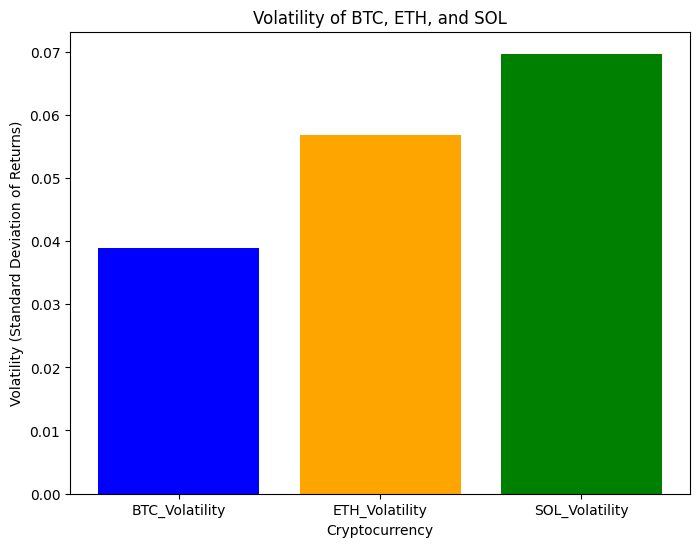

In [0]:
# Convert the Spark DataFrame to Pandas
volatility_pd = volatility_data.toPandas()

# Transpose the DataFrame to make plotting easier
volatility_pd = volatility_pd.transpose().reset_index()

# Rename columns for clarity
volatility_pd.columns = ['Cryptocurrency', 'Volatility']

# Plot the bar chart for volatility
plt.figure(figsize=(8, 6))
plt.bar(volatility_pd['Cryptocurrency'], volatility_pd['Volatility'], color=['blue', 'orange', 'green'])

# Add labels and title
plt.xlabel('Cryptocurrency')
plt.ylabel('Volatility (Standard Deviation of Returns)')
plt.title('Volatility of BTC, ETH, and SOL')

# Show the plot
plt.show()

%md
<h3>Description:</h3>

<p>
    In this section, we perform an aggregation of cryptocurrency return data by month and year. The goal is to calculate the average monthly returns for Bitcoin (BTC), Ethereum (ETH), and Solana (SOL) over the entire period of available data. Aggregating returns in this manner allows us to analyze trends and compare the performance of these cryptocurrencies on a monthly basis.
</p>

<p>
    The steps include:
</p>

<ul>
    <li><strong>Aggregation by Month and Year:</strong> Using Spark SQL functions, we group the data by year and month, and calculate the average daily returns for each cryptocurrency within each month. This helps in smoothing out daily volatility and provides a clearer picture of the monthly performance.</li>
    <li><strong>Renaming Columns:</strong> For clarity, we rename the resulting columns to explicitly indicate that they represent average monthly returns for BTC, ETH, and SOL. This makes the data easier to understand and work with in subsequent analysis.</li>
    <li><strong>Data Preview:</strong> Finally, we display the first few rows of the aggregated data to verify that the operations were successful and the data is in the expected format.</li>
</ul>

<p>
    This aggregation step is essential for transforming the raw daily return data into a more interpretable format. By focusing on monthly averages, we can identify broader trends and compare the performance of different cryptocurrencies over time, making it easier to draw meaningful insights from the data.
</p>


In [0]:
from pyspark.sql.functions import year, month

# Aggregate the data by month and year
monthly_returns = combined_data.groupBy(year("Date").alias("Year"), month("Date").alias("Month")).agg(
    {"BTC_Return": "avg", "ETH_Return": "avg", "SOL_Return": "avg"}
).orderBy("Year", "Month")

# Rename columns for clarity
monthly_returns = monthly_returns.withColumnRenamed("avg(BTC_Return)", "Avg_BTC_Return")\
                                 .withColumnRenamed("avg(ETH_Return)", "Avg_ETH_Return")\
                                 .withColumnRenamed("avg(SOL_Return)", "Avg_SOL_Return")

# Show the aggregated data
monthly_returns.show(5)

+----+-----+--------------+--------------+--------------------+
|Year|Month|Avg_ETH_Return|Avg_SOL_Return|      Avg_BTC_Return|
+----+-----+--------------+--------------+--------------------+
|2013|    4|          NULL|          NULL|0.001154661473610...|
|2013|    5|          NULL|          NULL|2.887921871493924E-4|
|2013|    6|          NULL|          NULL|-0.00945664812332...|
|2013|    7|          NULL|          NULL|0.006665944331674262|
|2013|    8|          NULL|          NULL|0.007501604829305362|
+----+-----+--------------+--------------+--------------------+
only showing top 5 rows



<h3>Description:</h3>

<p>
    After aggregating the monthly returns for Bitcoin (BTC), Ethereum (ETH), and Solana (SOL), we proceed to visualize the data using a bar chart. This visualization provides a clear comparison of the average monthly returns for each cryptocurrency over time, allowing us to easily identify trends, patterns, and periods of higher or lower returns.
</p>

<p>
    The steps include:
</p>

<ul>
    <li><strong>Data Preparation:</strong> The aggregated Spark DataFrame is converted into a Pandas DataFrame to facilitate easier manipulation and plotting. We also create a combined 'Year-Month' column to represent each month in a format suitable for labeling the x-axis.</li>
    <li><strong>Positioning Bars Side-by-Side:</strong> We calculate the positions on the x-axis where the bars for each cryptocurrency will be placed. By offsetting these positions slightly, we ensure that the bars for BTC, ETH, and SOL are displayed side by side, allowing for direct comparison.</li>
    <li><strong>Plotting the Bar Chart:</strong> A bar chart is generated with each bar representing the average monthly return for one cryptocurrency. The chart is color-coded, with different colors used for BTC, ETH, and SOL. Labels and a title are added to make the chart self-explanatory.</li>
    <li><strong>Improving X-Axis Readability:</strong> To avoid cluttering the x-axis, we display fewer labels by showing only every 6th month, while ensuring the most recent month is always included. The x-axis labels are rotated and aligned to enhance readability.</li>
</ul>

<p>
    This bar chart effectively highlights the performance of BTC, ETH, and SOL over time. By comparing the average monthly returns side by side, we can easily observe which cryptocurrency has performed better or worse during specific periods, offering valuable insights into market trends.
</p>


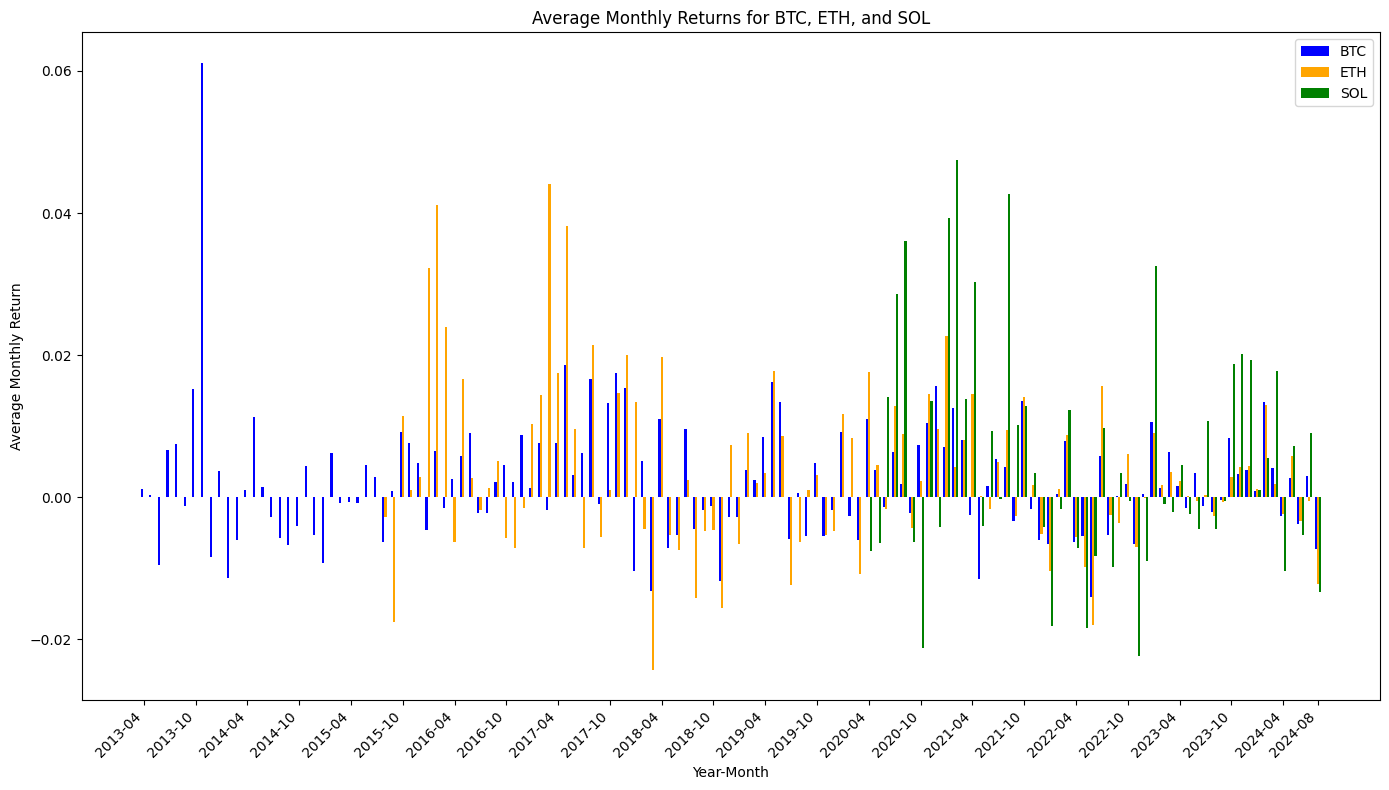

In [0]:
import matplotlib.pyplot as plt
import numpy as np

# Convert the aggregated data to a Pandas DataFrame
monthly_returns_pd = monthly_returns.toPandas()

# Create a combined 'Year-Month' column for plotting
monthly_returns_pd['YearMonth'] = monthly_returns_pd.apply(lambda row: f"{int(row['Year'])}-{int(row['Month']):02d}", axis=1)
# Number of months
n = len(monthly_returns_pd['YearMonth'])

# Position of bars on the x-axis
ind = np.arange(n)  

# Width of the bars
width = 0.25  

# Plot side-by-side bar charts
plt.figure(figsize=(14, 8))

plt.bar(ind - width, monthly_returns_pd['Avg_BTC_Return'], width, color='blue', label='BTC')
plt.bar(ind, monthly_returns_pd['Avg_ETH_Return'], width, color='orange', label='ETH')
plt.bar(ind + width, monthly_returns_pd['Avg_SOL_Return'], width, color='green', label='SOL')

# Add labels and title
plt.xlabel('Year-Month')
plt.ylabel('Average Monthly Return')
plt.title('Average Monthly Returns for BTC, ETH, and SOL')

# Show fewer x-axis labels and ensure the last one is included
xticks_indices = np.arange(0, n, 6).tolist()  # Show every 6th label
if n - 1 not in xticks_indices:
    xticks_indices.append(n - 1)  # Ensure the last date is included

plt.xticks(ind[xticks_indices], monthly_returns_pd['YearMonth'][xticks_indices], rotation=45, ha='right')

plt.legend()

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()


In [0]:
# Calculate the correlation between BTC and ETH daily returns
btc_eth_corr = combined_data.selectExpr("corr(BTC_Return, ETH_Return) as BTC_ETH_Correlation").show()


+-------------------+
|BTC_ETH_Correlation|
+-------------------+
| 0.5708311385258352|
+-------------------+



In [0]:
# Find the earliest date in the ETH dataset
eth_start_date = df_eth_transformed.agg({"Date": "min"}).collect()[0][0]

# Filter the combined dataset to include only data from when ETH started trading
filtered_data = combined_data.filter(combined_data["Date"] >= eth_start_date)

# Calculate the correlation between BTC and ETH returns since ETH started trading
btc_eth_corr_since_eth = filtered_data.selectExpr("corr(BTC_Return, ETH_Return) as BTC_ETH_Correlation_Since_ETH").show()


+-----------------------------+
|BTC_ETH_Correlation_Since_ETH|
+-----------------------------+
|           0.5708311385258352|
+-----------------------------+



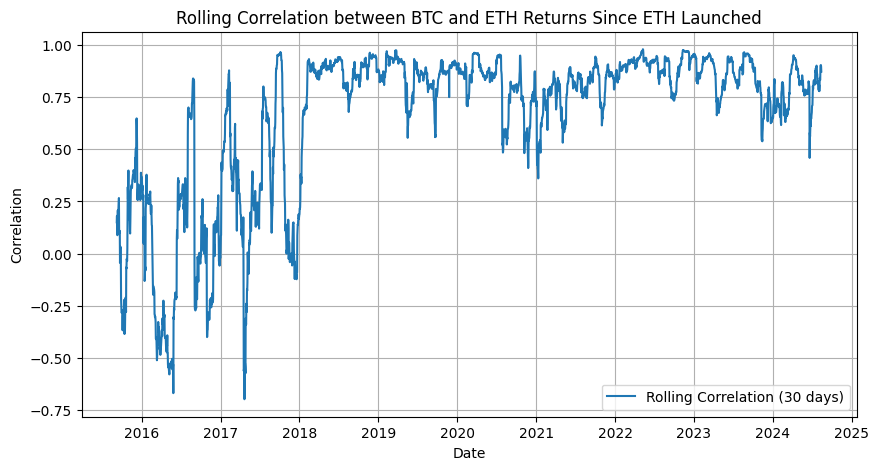

In [0]:
# Convert filtered data to Pandas DataFrame for plotting
filtered_data_pd = filtered_data.toPandas()

# Calculate rolling correlation since ETH launched
rolling_corr_since_eth = filtered_data_pd['BTC_Return'].rolling(window=30).corr(filtered_data_pd['ETH_Return'])

# Plot the rolling correlation
plt.figure(figsize=(10, 5))
plt.plot(filtered_data_pd["Date"], rolling_corr_since_eth, label="Rolling Correlation (30 days)")
plt.title("Rolling Correlation between BTC and ETH Returns Since ETH Launched")
plt.xlabel("Date")
plt.ylabel("Correlation")
plt.legend()
plt.grid(True)
plt.show()


In [0]:
# Calculate the correlation between the returns of BTC, ETH, and SOL
correlation_data = combined_data.selectExpr(
    "corr(BTC_Return, ETH_Return) as BTC_ETH_Correlation",
    "corr(BTC_Return, SOL_Return) as BTC_SOL_Correlation",
    "corr(ETH_Return, SOL_Return) as ETH_SOL_Correlation"
)

# Show the correlation
correlation_data.show()


+-------------------+-------------------+-------------------+
|BTC_ETH_Correlation|BTC_SOL_Correlation|ETH_SOL_Correlation|
+-------------------+-------------------+-------------------+
| 0.5708311385258352|  0.498594418925931| 0.5760195828561306|
+-------------------+-------------------+-------------------+

